In [5]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

In [49]:
n = 1000
m = 3*n
eps = 0.1
data_dim = 10
mu = 0
mu_out = 5
par_mu = np.full(data_dim, mu)
par_sd = np.eye(data_dim)
out_mu = np.full(data_dim, mu_out)
out_sd = np.eye(data_dim)
par_reg1 = 0.1
par_reg2 = 0.001
true_alpha = [par_mu, par_sd]

exper_iter = 5
optim_iter = 10
L = 200
learn_par = 1
dicay_par = 0.5

def sigmoid(x):
    return 1/(np.exp(-x) + 1)

def deriv_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def g_up(t, s):
    return sigmoid(s) + deriv_sigmoid(s)*(t-s) + (t-s)**2/20

def g_lo(t, s):
    return sigmoid(s) + deriv_sigmoid(s)*(t-s) - (t-s)**2/20

# 2次元正規分布plt用
def mean2scatter(res):
    npres = np.array(res)[0]
    for i in range(npres.shape[0]):
        if i< len(res[0])/2:
            x = npres[i,0]; y = npres[i,1]
            plt.scatter(x,y, color = "m")
        else:
            x = npres[i,0]; y = npres[i,1]
            plt.scatter(x,y, color = "c")
    plt.scatter(npres[0][0], npres[0][1], color = "r")
    plt.scatter(npres[-1][0], npres[-1][1], color = "b")


# l2ノルムをプロット
def l2_norm_plot(res, i=0):
    npres = np.array(res)
    x = range(len(npres[i]))
    y = npres[i] - par_mu
    y =  np.linalg.norm(y, ord = 2, axis = 1)
    plt.scatter(x,y)

In [ ]:
# 分散を単位行列で固定
res = [0 for i in range(exper_iter)]
for i in range(exper_iter):
    eps += 0.1/exper_iter
    print("%d/%d" %(i+1, exper_iter))
    data = np.random.multivariate_normal(mean = par_mu, cov = par_sd, size = int(n*(1-eps)))
    contamination = np.random.multivariate_normal(mean = out_mu, cov = out_sd, size = (n - int(n*(1-eps))))
    data = np.concatenate([data, contamination])
    np.random.shuffle(data)
    alpha_hist = []
    alpha = [np.median(data, axis=0), np.eye(data_dim)]
    for j in tqdm(range(1, optim_iter+1)):
        z = np.random.multivariate_normal(mean=alpha[0], cov=alpha[1], size = m)

        def major_func(par, past_par):
            new_beta = par[0:2*data_dim]; new_b = par[2*data_dim]; beta = past_par[0:2*data_dim]; b = past_par[2*data_dim]
            A = np.mean(g_lo(np.dot(np.stack([z, z**2], axis=1).reshape(m, 2*data_dim),new_beta) - new_b, np.dot(np.stack([z, z**2], axis=1).reshape(m, 2*data_dim),beta) - b))
            B = np.mean(g_up(np.dot(np.stack([data, data**2], axis=1).reshape(n, 2*data_dim),new_beta) - new_b, np.dot(np.stack([data, data**2], axis=1).reshape(n, 2*data_dim),beta) - b))
            return -(A-B)

        l = 0; par = np.random.normal(scale = 0.1, size = 2*data_dim + 1)
        while(l<L):
            op = minimize(major_func, x0 = np.zeros(2*data_dim +1), args = par)
            par = op.x
            l+=1
            
        alpha_m = alpha[0]; alpha_v = alpha[1]
        mgrad = (z-alpha_m)
        sig_ = sigmoid(np.dot(np.stack([z, z**2], axis=1).reshape(m, 2*data_dim),par[0:2*data_dim ])- par[2*data_dim])[:,np.newaxis]
        tmp_alpha = alpha[0] - learn_par/j**dicay_par * np.mean(mgrad*sig_, axis = 0)
        alpha[0] = tmp_alpha
        alpha_hist.append(alpha[0])
    res[i] = alpha_hist


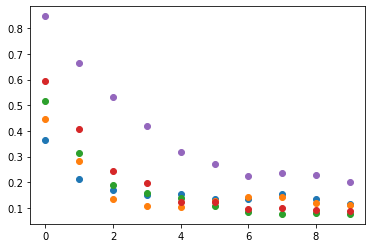

In [51]:
#n=1000, dim = 10, optim = 10, mm=200, eps = 0.12,0.14, ..,0.2
for i in range(exper_iter):
    l2_norm_plot(res, i)

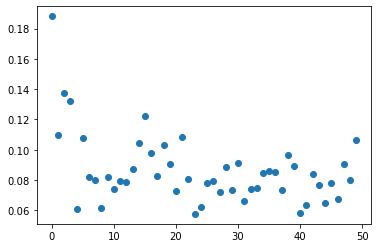

In [40]:
#n = 1000, dim = 10, optim=50, mm=200
l2_norm_plot(res)

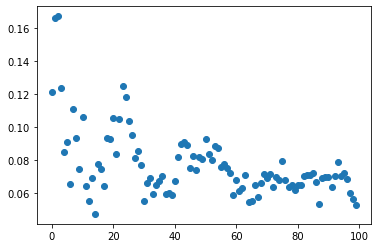

In [37]:
#n = 1000, dim = 10, optim=100, mm=100 -> mmの回数を増やしたほうが良い性能が出る？ optim減らしてもよさそう？
l2_norm_plot(res)

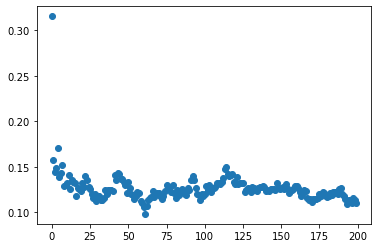

In [32]:
#n = 1000, dim = 10, optim=200, mm=50
l2_norm_plot(res)